# Ensemble Learning and Random Forests

Suppose you pose a complex question to thousands of random people, then aggregate their  answers.  In  many  cases  you  will  find  that  this  aggregated  answer  is  better  than an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate the  predictions  of  a  group  of  predictors  (such  as  classifiers  or  regressors),  you  will often  get  better  predictions  than  with  the  best  individual  predictor.  A  group  of  predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method. As an example of an Ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you obtain  the  predictions  of  all  the  individual  trees,  then  predict  the  class  that  gets  the most votes. Such an ensemble of Decision Trees is called  a  Random  Forest,  and  despite  its  simplicity,  this  is  one  of  the  most  powerfulMachine Learning algorithms available today. You  will  often  use  Ensemble  methods  near  the  end  of  aproject, once you have already built a few good predictors, to combine them into an even  better  predictor.  In  fact,  the  winning  solutions  in  Machine  Learning  competitions  often  involve  several  Ensemble  methods  (most  famously  in  the  Netflix  Prize competition). In  this  chapter  we  will  discuss  the  most  popular  Ensemble  methods,  including  bagging, boosting, and stacking. We will also explore Random Forests.

## Voting Classifiers

Suppose  you  have  trained  a  few  classifiers,  each  one  achieving  about  80%  accuracy. You  may  have  a  Logistic  Regression  classifier,  an  SVM  classifier,  a  Random  Forestclassifier, a K-Nearest Neighbors classifier, and perhaps a few more as in figure below.

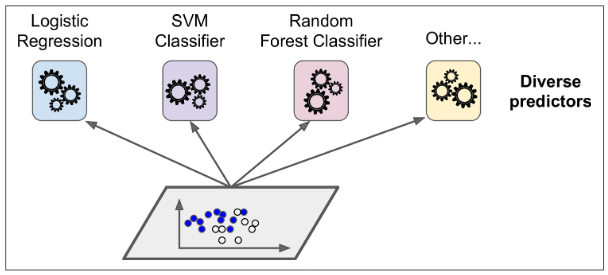

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier (fig below).

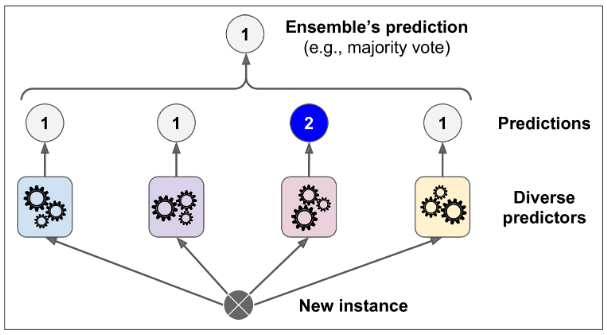

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning  it  does  only  slightly  better  than  random  guessing),  the  ensemble  can  still  be  a strong  learner  (achieving  high  accuracy),  provided  there  are  a  sufficient  number  of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose  you  have  a  slightly  biased  coin  that  has  a  51%  chance  of  coming  up  heads and  49%  chance  of  coming  up  tails.  If  you  toss  it  1,000  times,  you  will  generally  get more  or  less  510  heads  and  490  tails,  and  hence  a  majority  of  heads.  If  you  do  the math,  you  will  find  that  the  probability  of  obtaining  a  majority  of  heads  after  1,000 tosses  is  close  to  75%.  The  more  you  toss  the  coin,  the  higher  the  probability  (e.g. ,with  10,000  tosses,  the  probability  climbs  over  97%).  This  is  due  to  the  law  of  large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). Figure below shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.

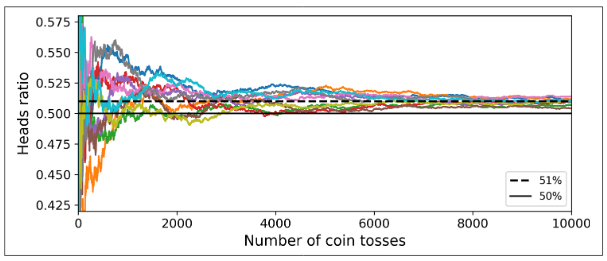

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually  correct  only  51%  of  the  time  (barely  better  than  random  guessing).  If  you  predict  the  majority  voted  class,  you  can  hope  for  up  to  75%  accuracy!  However,  this  is only  true  if  all  classifiers  are  perfectly  independent,  making  uncorrelated  errors, which is clearly not the case because they are trained on the same data. They are likelyto make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

The following code creates and trains a voting classifier in Scikit-Learn, composed of three  diverse  classifiers  (the  training  set  is  the  moons  dataset):

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_test) #training data is not created create

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

The  voting  classifier  slightly  outperforms  all  the  individual classifiers. If  all  classifiers  are  able  to  estimate  class  probabilities  (i.e.,  they  all  have  a  predict_proba()  method),  then  you  can  tell  Scikit-Learn  to  predict  the  class  with  the highest class probability, averaged over all the individual classifiers. This is called softvoting.  It  often  achieves  higher  performance  than  hard  voting  because  it  gives  more weight  to  highly  confident  votes.  All  you  need  to  do  is  replace  voting="hard"  with voting="soft"  and  ensure  that  all  classifiers  can  estimate  class  probabilities.  This  is not  the  case  for  the  SVC  class  by  default,  so  you  need  to  set  its  probability  hyper‐parameter to True (this will make the SVC class use cross-validation to estimate class probabilities,  slowing  down  training,  and  it  will  add  a  predict_proba()  method).  If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91.2% accuracy!

## Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as  just  discussed.  Another  approach  is  to  use  the  same  training  algorithm  for  every predictor and train them on different random subsets of the training set. When sampling  is  performed  with  replacement,  this  method  is  called  bagging (short  for  boot‐strap  aggregating).  When  sampling  is  performed  without  replacement,  it  is  called pasting.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled  several  times  for  the  same  predictor.  This  sampling  and  training  process  is represented in Figure below.

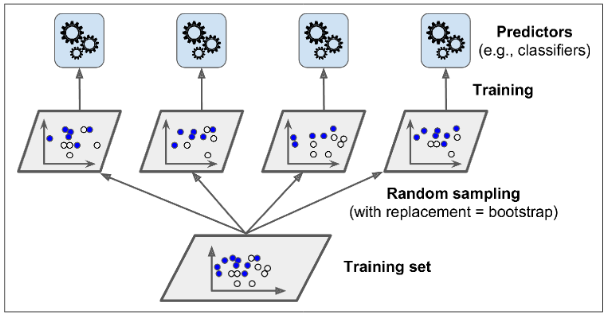

Once  all  predictors  are  trained,  the  ensemble  can  make  a  prediction  for  a  new instance  by  simply  aggregating  the  predictions  of  all  predictors.  The  aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor  has  a  higher  bias  than  if  it  were  trained  on  the  original  training  set,  but aggregation  reduces  both  bias  and  variance.  Generally,  the  net  result  is  that  the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

As  you  can  see  in  Figure  above,  predictors  can  all  be  trained  in  parallel,  via  different CPU  cores  or  even  different  servers.  Similarly,  predictions  can  be  made  in  parallel. This is one of the reasons bagging and pasting are such popular methods: they scale very well.

## Baggin and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier  class  (or  BaggingRegressor  for  regression).  The  following  code  trains  anensemble  of  500  Decision  Tree  classifiers:  each  is  trained  on  100  training  instances randomly sampled from the training set with replacement (this is an example of bagging,  but  if  you  want  to  use  pasting  instead,  just  set  bootstrap=False).  The  n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (-1 tells Scikit-Learn to use all available cores):

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The BaggingClassifier    automatically    performs    soft    voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Tree classifiers.

Figure below compares  the  decision  boundary  of  a  single  Decision  Tree  with  the  decision  boundary  of  a  bagging  ensemble  of  500  trees  (from  the  preceding  code),  both trained  on  the  moons  dataset.  As  you  can  see,  the  ensemble’s  predictions  will  likely generalize much better than the single Decision Tree’s predictions: the ensemble has acomparable bias but a smaller variance (it makes roughly the same number of errorson the training set, but the decision boundary is less irregular).

max_samples can alternatively be set to a float between 0.0 and 1.0, in which case the max number of instances to sample is equal to the size of the training set times max_samples.

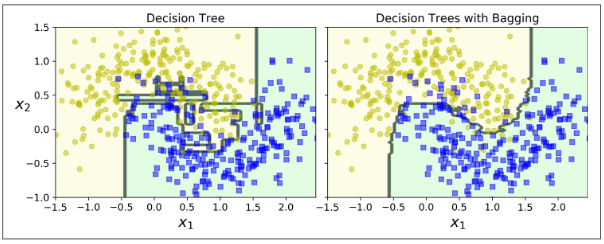

Bootstrapping  introduces  a  bit  more  diversity  in  the  subsets  that  each  predictor  is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance  is  reduced.  Overall,  bagging  often  results  in  better  models,  which  explain swhy  it  is  generally  preferred.  However,  if  you  have  spare  time  and  CPU  power,  you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while  others  may  not  be  sampled  at  all.  By  default  a  BaggingClassifier  samples  m training  instances  with  replacement  (bootstrap=True),  where  m  is  the  size  of  the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled  are  called  out-of-bag  (oob)  instances.  Note  that  they  are  not  the  same  37% for all predictors. Since a predictor never sees the oob instances during training, it can be evaluated on these  instances,  without  the  need  for  a  separate  validation  set.  You  can  evaluate  the ensemble itself by averaging out the oob evaluations of each predictor. In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstratesthis. The resulting evaluation score is available through the oob_score_ variable:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train) # needed code completion
bag_clf.oob_score_

According  to  this  oob  evaluation,  this  BaggingClassifier  is  likely  to  achieve  about 90.1% accuracy on the test set. Let’s verify this:

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

We get 91.2% accuracy on the test set—close enough! The  oob  decision  function  for  each  training  instance  is  also  available  through  the oob_decision_function_  variable.  In  this  case  (since  the  base  estimator  has  a  predict_proba() method), the decision function returns the class probabilities for each training  instance.  For  example,  the  oob  evaluation  estimates  that  the  first  training instance  has  a  68.25%  probability  of  belonging  to  the  positive  class  (and  31.75%  of belonging to the negative class):

In [2]:
bag_clf.oob_decision_function_

NameError: name 'bag_clf' is not defined

## Random Patches and Random Subspaces

The  BaggingClassifier  class  supports  sampling  the  features  as  well.  Sampling  is controlled  by  two  hyperparameters:  max_features  and  bootstrap_features.  They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features. This  technique  is  particularly  useful  when  you  are  dealing  with  high-dimensional inputs  (such  as  images).  Sampling  both  training  instances  and  features  is  called  the Random Patches method. Keeping all training instances (by setting bootstrap=False and max_samples=1.0) but sampling features (by srtting bootstrap_features to True and/or max_features to a value smaller then 1.0) is called the Random Subspaces method.